# Spectral Analysis of Temperature 12k records using `Pyleoclim` 

by [Alexander James](https://alexkjames.github.io)

In this notebook, we demonstrate how to use [Pyleoclim](https://medium.com/cyberpaleo/introducing-pyleoclim-paleoclimate-timeseries-analysis-and-visualization-with-python-5b33f384e93) to perform spectral analysis on the [Temperature 12k Database](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/noaa-recon-27330/html).

Technical skills involved:
- loading data in the [LiPD](https://lipd.net) format.
- applying and interpreting spectral analysis in Pyleoclim
- estimating scaling exponents from [PSD objects](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#psd-pyleoclim-psd)


First, let's import some useful packages, including `Pyleoclim`.

In [1]:
# load pacakges
%load_ext autoreload
%autoreload 2
    
import pyleoclim as pyleo
import os
import numpy as np
from tqdm import tqdm 
import pickle

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

## Load LiPD files with `Pyleoclim`

The LiPD version of the dataset can be downloaded [here](http://lipdverse.org/globalHolocene/current_version/globalHolocene1_0_0.zip).
Note that the record "RainbowLake.Shuman.2016.lpd" is problematic and a fix of it can be downlowded [here](https://github.com/LinkedEarth/LiPDbooks/raw/master/notebooks/lipd/RainbowLake.Shuman.2016.lpd).

Suppose the LiPD files of the dataset are stored in the folder named "globalHolocene1_0_0", to load the whole dataset, simply use `pyleo.Lipd()` with its argument `usr_path` pointing to the relative path of the folder.
The resultant `dataset` is a LiPD utility object that has a method called `to_tso()`, which will extract the timeseries records to a Python list for us.

In [5]:
# load the LiPD dataset
dataset = pyleo.Lipd(usr_path='./globalHolocene1_0_0/')

# convert the input dataset into a list of LiPD timeseries objects,
# each object is essentially a dictionary
ts_list = dataset.to_tso()

## Define `Pyleoclim.Series()` objects

Once we have the timeseries records from the LiPD files, we may loop over each record and convert it to a `Pyleoclim.Series()` object, which has a collection of handy *methods* for data analysis.

Note that we use a dictionary called `ts` to store each record, with the key name as the `dataSetName` from each record.
We also store the latitude information of each record into a dictionary called `lats`.

In [8]:
ts = {}  # the dictionary for Pyleoclim Series objects
lats = {} # the dictionary for latitude information of the proxies

# load the data used in global temperature analysis
flag = 'paleoData_useInGlobalTemperatureAnalysis'

# a list of problematic records that we will skip
skip_list = [
    'GRIP.Vinther.2006',
    'Vuoksjavratje.Berntsson.2014',
    'Sigrid.Nazarova.2017',
    'DavisLake.Barnosky.1981',
    'Ammersee.vonGrafenstein.1996',
    'Temje.Nazarova.2013',
]

def replaceNaN(value):
    ''' replace "nan" in value with np.nan
    '''
    value_list = []
    for v in value:
        if v == 'nan':
            value_list.append(np.nan)
        else:
            value_list.append(v)
            
    return value_list
        

for item in tqdm(ts_list):
    dsn = item['dataSetName']
    if flag in item.keys() and item[flag] == 'TRUE':
        value = item['paleoData_values']
        value = replaceNaN(value)
            
        if 'year' in item.keys():
            year = item['year']
            year = replaceNaN(year)
            
        elif 'age' in item.keys():
            age = item['age']
            age = replaceNaN(age)
            year = 1950-np.array(age)
        else:
            # no time axis, skip
            continue
            
        # define the Pyleoclim timseries object and
        # store in a dictionary with dataSetName as the key
        if dsn in skip_list:
            continue
            
        ts[dsn] = pyleo.Series(time=year, value=value)
        lats[dsn] = item['geo_meanLat']

print('# of loaded timeseries:', len(ts))

# dump to a pickle file for quick load in the future
with open('./data/lats_dict.pkl', 'wb') as f:
    pickle.dump(lats, f)

100%|██████████| 9917/9917 [00:00<00:00, 64703.21it/s]

695


## Spectral analysis with `Pyleoclim`

### Applying the WWZ method
Now we are ready to perform spectral analysis for each `Series()` object.

We will first standardize each timeseries and then perform the WWZ method ([Kirchner and Neal, 2013](www.pnas.org/content/110/30/12213)) for power spectral density (PSD) calculation.
In `Pyleoclim`, those two steps can be a one line call.
Suppose the timeseries objection is named as `ts_obj`, then `ts_obj.standardize()` will perform the standardization process, and we can append `.spectral()` to perform spectral analysis on the standardized timeseries directly.
In short, it's simply `ts_obj.standardize().spectral()`, whose output is a `Pyleoclim.PSD()` object and it will be stored in a dictionary for each record.

There are several important arguments for the `.spectral()` method though, including:
1. `method` - here we use the default option `wwz`, so this argument can be ignored
2. `freq_method` - here we use the default option `log`, which means a log-space frequency vector for analysis, so this argument can be ignored
3. `freq_kwargs` - here we specify the length of the frequency vector `nfreq` to control the calculation speed (the longer the length, the longer time it will take)

In [15]:
psd = {}  # the dictionary to store the spectral analysis result for each record

# spectral analysis for each record; it would take about 1 hour for the calculation
for dsn, ts_obj in tqdm(ts.items()):
    nfreq = np.min([20, np.size(ts_obj.time)]) # length of the frequency vector as a control of the calculation speed
    if dsn not in psd.keys():
        psd[dsn] = ts_obj.standardize().spectral(
            method='wwz',  # the default option
            freq_method='log', # the default option
            freq_kwargs={'nfreq': nfreq}
        )
        
# dump to a pickle file for quick load in the future
with open('./data/psd_objs.pkl', 'wb') as f:
    pickle.dump(psd, f)

100%|██████████| 695/695 [51:12<00:00,  4.42s/it]  


### Scaling slope estimation

Once the PSD is calculated for each record, we may estimate the scaling slope $\beta$ of the PSD curves using the `.beta_est()` method on each `PSD()` object.
We need to specify two arguments for the `.beta_est()` method:
1. `fmin`: which defines the minimum edge of the range for $\beta$ estimation
2. `fmax`: which defines the maxmimum edge of the range for $\beta$ estimation

We will calculate three sets of the scaling factors:
1. period over [10, 100] yrs
2. period over [100, 1000] yrs
3. period over [1000, 10000] yrs

In [3]:
# load the precalculated PSD objects
with open('./data/psd_objs.pkl', 'rb') as f:
    psd = pickle.load(f)
    
beta_S = []
beta_M = []
beta_L = []

for dsn, psd_obj in psd.items():
    beta_S.append(
        psd_obj.beta_est(fmin=1/100, fmax=1/10)['beta']
    )
    beta_M.append(
        psd_obj.beta_est(fmin=1/1000, fmax=1/100)['beta']
    )
    beta_L.append(
        psd_obj.beta_est(fmin=1/10000, fmax=1/1000)['beta']
    )
    
beta_S = np.array(beta_S)
beta_M = np.array(beta_M)
beta_L = np.array(beta_L)

beta_S = beta_S[~np.isnan(beta_S)]
beta_M = beta_M[~np.isnan(beta_M)]
beta_L = beta_L[~np.isnan(beta_L)]

nS = len(beta_S)
nM = len(beta_M)
nL = len(beta_L)
print(nS, nM, nL)

30 184 46


## Visualization with `Pyleoclim`

Now the calculation is done, let's visualize the result.

First, it's easy to set the plotting style with `Pyleoclim`, simply use `pyleo.set_style()`, which has two important arguments:
1. `style` - a text string to specify which plotting style to use
2. `font_scale` - which can be used to scale the font sizes consistently for a figure
Here we will use the default `journal` plotting style, with `font_scale=1.5` for better readability.
For more details of `pyleo.set_style()`, see [this notebook](https://github.com/LinkedEarth/Pyleoclim_util/blob/Development/example_notebooks/plot_styles.ipynb).

`Pyleoclim` makes it also super easy for quick visualization of the `Series()` and `PSD()` objects.
It's simply `Series.plot()` or `PSD.plot()`.
Regarding `PSD.plot()`, we have several important arguments:
1. `ax` - if specified, the plot will be output to an existing `matplotlib.axes` object
2. `xlim` - if specified, the x-axis of the plot will be limited within the specified range
3. `ylim` - if specified, the y-axis of the plot will be limited within the specified range
4. `xlabel` - if specified, the x-axis will be labeled with the specified text string
5. `ylabel` - if specified, the y-axis will be labeled with the specified text string
6. `color` - if specified, the curve will be colored with the specified color
7. `mute` - if True, the figure object `fig` will not be visible, until `pyleo.showfig(fig)` is called

Note that we will specify `ax` when loop over records, so as to overlap multiple PSD curves into one figure, and we show how to do it below.

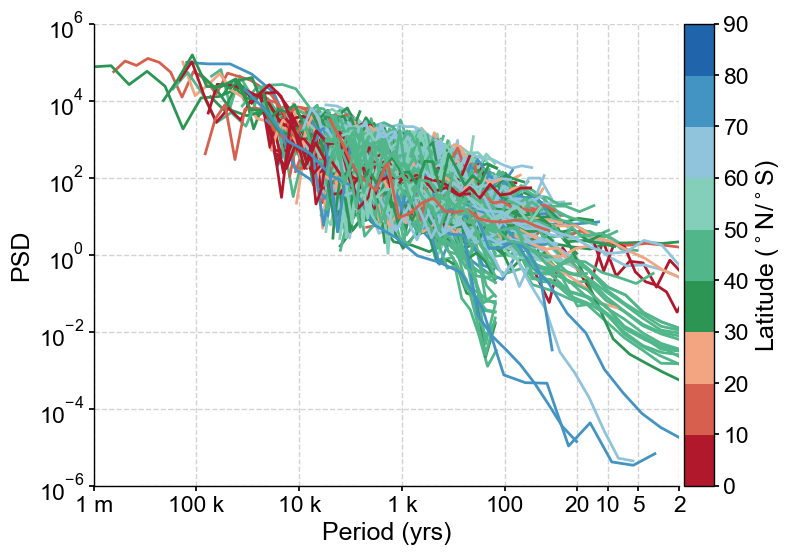

In [4]:
# define a colormap for different latitudes
with open('./data/lats_dict.pkl', 'rb') as f:
    lats = pickle.load(f)
    
lat_list = [v for k, v in lats.items()]
cmap = sns.color_palette("RdBu_r", 9)[::-1]
cmap_green = sns.color_palette("BuGn_r")
cmap[3:6] = cmap_green[1:4]
color_ind_list = np.abs(lat_list)//10
color_ind_list = color_ind_list.astype(int)

# plot the PSD curves colored according to latitudes
    
# set the plotting style
pyleo.set_style(style='journal', font_scale=1.5)

period_ticks = [2, 5, 10, 20, 100, 1000, 10000, 100000, 1000000]
period_ticklabels = ['2', '5', '10', '20', '100', '1 k', '10 k', '100 k', '1 m']
    
dsns = psd.keys()
psd_obj = psd[list(dsns)[0]]
fig, ax = psd_obj.plot(mute=True, figsize=[8, 6]) # plot the first PSD curve
for dsn, psd_obj in psd.items():
    # loop over and plot the PSD curves of other records
    if dsn == list(dsns)[0]:
        pass
    else:
        i = list(dsns).index(dsn)
        psd_obj.plot(
            ax=ax, xlim=[1e6, 1e1], ylim=[1e-6, 1e6],
            xlabel='Period (yrs)', ylabel='PSD',
            color=cmap[color_ind_list[i]],
        )
        
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
        
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
clr_map = mpl.colors.ListedColormap(cmap)
cax = divider.append_axes("right", size="5%", pad=0.05)
bounds = np.linspace(0, 90, 10)
cb = mpl.colorbar.ColorbarBase(cax, cmap=clr_map, orientation='vertical', boundaries=bounds,
                               ticks=bounds)
cb.set_label(r'Latitude ($^\circ$N/$^\circ$S)')
        
pyleo.showfig(fig)

The PSD curves are now plotted, it's time to visualize the estimated scaling slopes - the $\beta$ values.

Below we show how to plot KDE of the $\beta$ values of those PSD curves utilizating another visualization package [seaborn](https://seaborn.pydata.org).

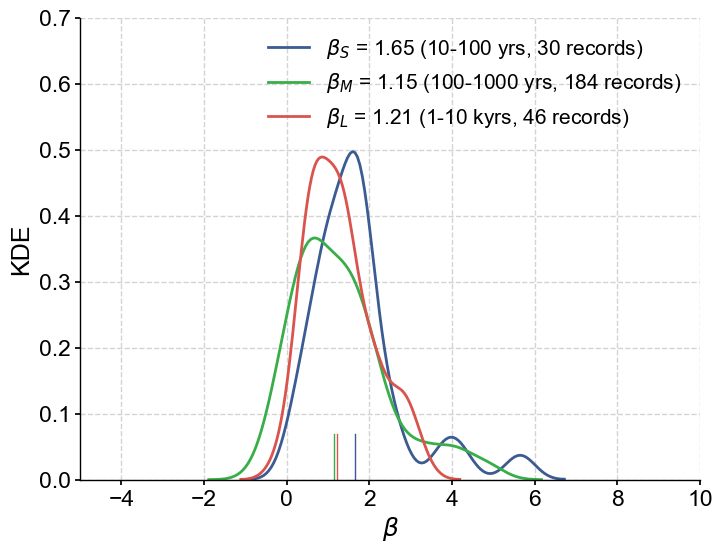

In [5]:
# set the plotting style
pyleo.set_style(style='journal', font_scale=1.5)

fig, ax = plt.subplots(figsize=[8, 6])
med_s = np.median(beta_S)
med_m = np.median(beta_M)
med_l = np.median(beta_L)
n_s = beta_S.shape[0]
n_m = beta_M.shape[0]
n_l = beta_L.shape[0]

ax.set_xlim([-5, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

g1 = sns.kdeplot(beta_S, shade=False, color=sns.xkcd_rgb['denim blue'], linestyle='-',
                 label=r'$\beta_S$ = {:.2f} (10-100 yrs, {} records)'.format(med_s, n_s))
g1.axvline(x=med_s, ymin=0, ymax=0.1, linewidth=1, color=sns.xkcd_rgb['denim blue'],
           linestyle='-')

g2 = sns.kdeplot(beta_M, shade=False, color=sns.xkcd_rgb['medium green'], linestyle='-',
                 label=r'$\beta_M$ = {:.2f} (100-1000 yrs, {} records)'.format(med_m, n_m))
g2.axvline(x=med_m, ymin=0, ymax=0.1, linewidth=1, color=sns.xkcd_rgb['medium green'], linestyle='-')

g3 = sns.kdeplot(beta_L, shade=False, color=sns.xkcd_rgb['pale red'], linestyle='-',
                 label=r'$\beta_L$ = {:.2f} (1-10 kyrs, {} records)'.format(med_l, n_l))
g3.axvline(x=med_l, ymin=0, ymax=0.1, linewidth=1, color=sns.xkcd_rgb['pale red'], linestyle='-')

ax.set_ylim(0, 0.7)
ax.legend(fontsize=15, loc='upper right',  bbox_to_anchor=(1, 1))
ax.set_ylabel('KDE')
ax.set_xlabel(r'$\beta$')
pyleo.showfig(fig)

We see that scaling exponents cover a broad range. Similar methods can be applied to explore how scaling behavior is affected by various factors, including archive type.  